 ## Multi-band detection by pixel-level clustering

[*This is not a thorough application, more a quick test if the idea has merit. And we'll do some serious harm to error propagation…*].

Traditionally astronomical image analysis is performed in individual bands. You take an image, say in the optical $r-$band, detect objects there, and determine their properties. If you have multiple bands, you repeat the process for each band. That's weird because we naturally expect images to have colors. What if we did our analyses on multi-band image cubes? We'd have more information and access to alternative ways of looking at the data. And we could play with analysis methods that are often associated with catalog-level data, but this time we use them directly on pixels.

I will attempt to do detection and segmentation (finding out which pixel belong to which object) by looking for pixels with similar colors, in other words *clustering* in a suitable color space. I made an example image with 3 objects in a 3-band image cube: 

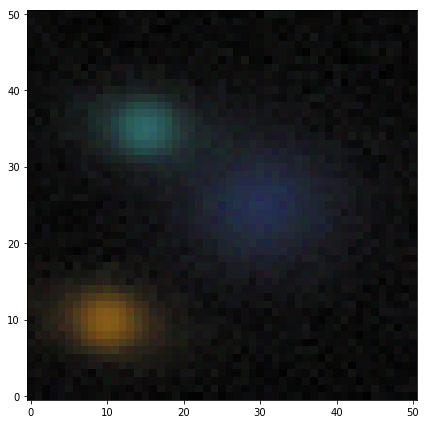

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.aspect'] = 'equal'
plt.rcParams['figure.figsize'] = [6,6]

def rgb_arcsinh_scaling(img, zero=0):
    img_tot = img.sum(axis=0)
    # combine to RGB cube with arcsinh scaling
    scaled = np.arcsinh((img_tot-zero)/np.std(img_tot)*5)
    scaled = (scaled - scaled.min()) / (scaled.max() - scaled.min())
    # needs to be a (N,M,3)
    rgb = np.moveaxis(img[::-1,:,:] * (scaled / img_tot)[None,:,:], 0,2)
    return rgb

# load simulated 3-band image:
img = np.load("3-band-example.npy").astype('float')
B,Ny,Nx = img.shape
sky = 100
rgb = rgb_arcsinh_scaling(img, zero=sky*B)
plt.figure()
plt.imshow(rgb)
plt.tight_layout()
plt.show()

What you get is the traditional way of looking at it as false-color image (with a visually pleasing arcsinh stretch), which is ordered by pixel position. But what about flipping this: the same data, but now ordered by intensity in $gri$, each dot is one pixel.

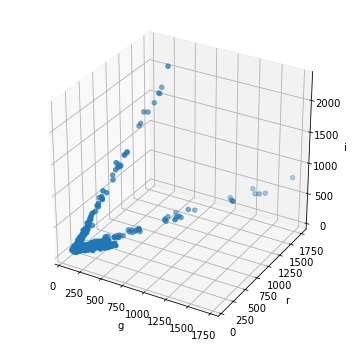

In [2]:
# plot the 3-band color space
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(img[0].flatten(), img[1].flatten(), img[2].flatten())
ax.set_xlabel('g')
ax.set_ylabel('r')
ax.set_zlabel('i')
plt.show()

One can see three distinct groups of pixels, distributed along straight lines of different direction. That's because the relative amplitude in different bands is the same (modulo noise), but the overall intensity is changing. The brightest pixels of each object is at the tip of each branch. The three branches merge in one common point, which is the sky intensity.

Before we attempt a clustering analysis, we might want to do a dimensionality reduction. After all, these straight lines are entirely predictable. I tried several methods from scikit-learn, but none worked satisfactorily. If someone knows a reduction technique in scikit-learn that compresses those linear branches to points, let me know! In the meantime, we have to think of something else.

A transformation that nulls the intensity variation is to normalize by the sum of intensities in all bands $b$:
$$
I^\prime_{b,i,j} = I_{b,i,j} \Big/ \sum_b I_{b,i,j}
$$
Now all samples have $\sum_b I^\prime_{b,i,j}=1$ in intensity space, a constraint that is called a [simplex](https://en.wikipedia.org/wiki/Simplex). But we're still in 3D. However, since the "length" of the intensity vectors is irrelevant, only the direction matters. We can go the origin of the intensity space, $(0,0,0)$ in the right image above, and project out the length direction. That's equivalent to looking at the sky and ignoring the distances to all stars/galaxies. I will call the resulting space the **color space**.

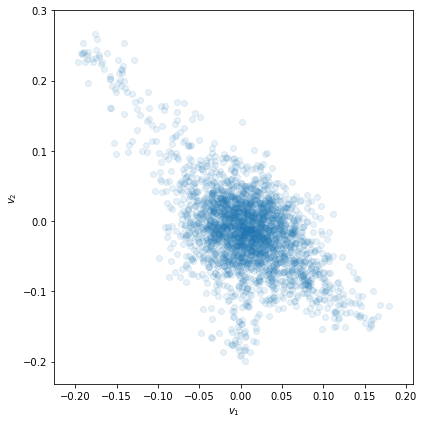

In [3]:
def simplex_projection(img):
    # normalize total intensity
    img_tot = img.sum(axis=0)
    # yeah: division by zero happens here!
    v = img.astype('float') / img_tot[None,:,:]

    # build basis of simplex
    d = img.shape[0]
    basis = np.zeros((d,d))
    # set normal on simplex
    basis[:,0] = 1
    for i in xrange(1,d):
        basis[0,i] = -1
        basis[i,i] = 1
    q,r = np.linalg.qr(basis)

    # remove projection onto normal
    w = q[:,1:].T
    v = np.einsum('ij,j...', w, v)
    return v

# project 3-band data onto 2-dim simplex
v = simplex_projection(img)
v = v.reshape(-1,2)
# plot the 2D distribution: surface of simplex
plt.figure()
sc = plt.scatter(v[:,0], v[:,1], alpha=0.1)
plt.xlabel('$v_1$')
plt.ylabel('$v_2$')
plt.tight_layout()
plt.show()

The big blob in the center the color of the sky. I used 100 counts in every band, so the sky color is gray, and it's at the center of the simplex. Every color in the image is a mixture of the sky color and the color of one or several objects, the relative ratios create the branches in the left panel. The brightest pixels of each objects are still at the tips of the branches.

To get rid of the sky, one can subtract it before projecting onto the simplex. **But that causes the mean of the denominator of the simplex normalization to be zero!** Division by zero or very small numbers is usually not a good idea, but let's try anyway. What you get is the right panel above *if you trim it to 2D distances of <0.75* (that number is hand-picked).

/Users/pmelchior/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/Users/pmelchior/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/Users/pmelchior/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


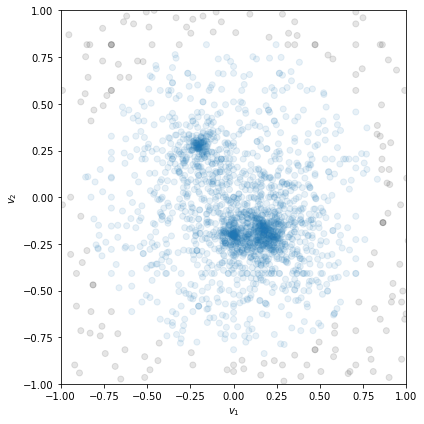

In [4]:
# for better separation: remove the sky
v = simplex_projection(img-sky)
v = v.reshape(-1,2)
# exclude "bad" pixels
sel = np.isnan(v[:,0]) | np.isnan(v[:,1])
# prune the noise
noise_thresh = 0.75
sel |= (v**2).sum(axis=1) > noise_thresh
v_ = v[~sel]

# plot the 2D distribution: surface of simplex
plt.figure()
colors = np.array([[0,0,0], sc.get_facecolors()[0]])
plt.scatter(v[:,0], v[:,1], alpha=0.1, c=colors[(~sel).astype('int')])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.yticks(plt.xticks()[0])
plt.xlabel('$v_1$')
plt.ylabel('$v_2$')
plt.tight_layout()
plt.show()

There are many outliers (black markers) whose color are very close to the sky, so their color after subtraction becomes rather ill-defined. Nonetheless, the brighter pixels here form three groups, two of which quite strongly overlap. But that should be good enough to run a simple clustering algorithm. Following the decision tree from scikit-learn I picked the simplest one, $k$-means:

In [5]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=3)
labels_ = kmeans.fit_predict(v_)
# get lables for every sample, even outliers (assigned label =0)
labels = np.zeros(len(v), dtype='int')
labels[~sel] = labels_ + 1

OK, that was easy. But was it any good?

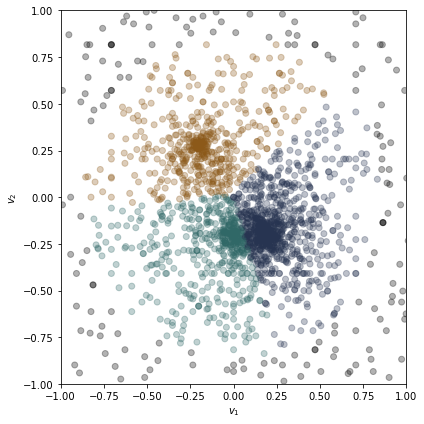

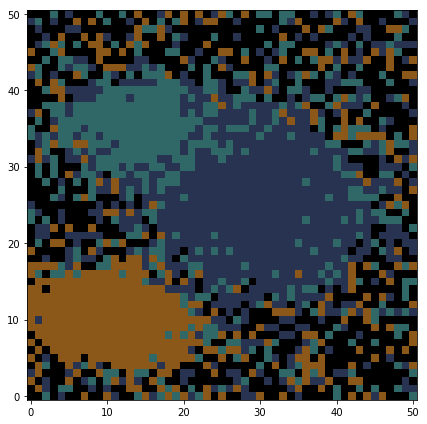

In [6]:
def plotWithLabels(v, labels):
    # get peak colors for labels later
    xs = 10,15,30
    ys = 10,35,25
    pos = zip(ys,xs)
    colors = np.array([np.array([0,0,0])] + [rgb[y,x,:] for (y,x) in pos])

    # align the labels with the peak order from the image, so that colors match
    pixel_labels = labels.reshape((Ny,Nx))
    peak_labels = [pixel_labels[y,x] for (y,x) in pos]
    labels_ = labels.copy()
    for k in range(len(pos)):
        mask = labels == peak_labels[k]
        labels_[mask] = k + 1
    plt.figure()
    plt.scatter(v[:,0], v[:,1], c=colors[labels_], alpha=0.3)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.yticks(plt.xticks()[0])
    plt.xlabel('$v_1$')
    plt.ylabel('$v_2$')
    plt.tight_layout()

    plt.figure()
    segmentation = np.zeros((Ny,Nx,3))
    for k in range(len(pos)):
        mask = pixel_labels == peak_labels[k]
        segmentation[mask] = colors[k + 1]
    plt.imshow(segmentation)
    plt.tight_layout()
    plt.show()


plotWithLabels(v, labels)

Well, $k$-means found a clustering in color space that looks plausible. I used the colors that correspond to the ones in the original image. I ran this a few times and the only aspect that changes is the boundary between the cyan and blue cluster. Not surprising, since these objects have similar colors.

Using those color-based labels, we can now ask: which pixel belongs to which object in the image (right panel). We can see that, by and large, the detection and segmentation is indeed quite plausible. The brighter pixels are correctly associated with a single object. Black pixels in this image are the ones we needed to exclude as outliers before, and indeed they are preferentially from regions that should be mostly sky.

This concludes my simple example of multi-band detection by color only. Note that we didn't use any spatial information, and still we got something that makes sense. Color is a powerful discriminator!

Do you have ideas how to improve upon that?